In [5]:
import os
import matplotlib.pyplot as plt
import numpy as np
import openai
import yaml

from utils import *

import autoKG_full as AKG

In [6]:
with open("config.yaml", 'r') as stream:
    try:
        params = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)


COMPLETIONS_MODEL = params["OPENAI_API_MODEL"]
EMBEDDING_MODEL = params["EMBEDDING_MODEL"]
my_api_key = params["OPENAI_API_KEY"]
openai.api_key = my_api_key

os.environ['OPENAI_API_KEY'] = my_api_key
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

OLLAMA_BASE_URL = params["OLLAMA_BASE_URL"]

In [7]:
KG_class_chat = AKG.autoKG(texts=None,
                           source=None,
                           embedding_model=EMBEDDING_MODEL,
                           llm_model=COMPLETIONS_MODEL,
                           openai_api_key=OPENAI_API_KEY,
                           main_topic=None,
                           ollama_base_url=OLLAMA_BASE_URL,
                           embedding=False)

In [8]:
KG_class_chat.load_data(os.path.join('KG_data', 'ref_paper_KG.npy'), include_texts=True)

Successfully load from KG_data\ref_paper_KG.npy


C:\Users\HowieXie\AppData\Local\Temp\ipykernel_43048\2287119128.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', n_clusters)


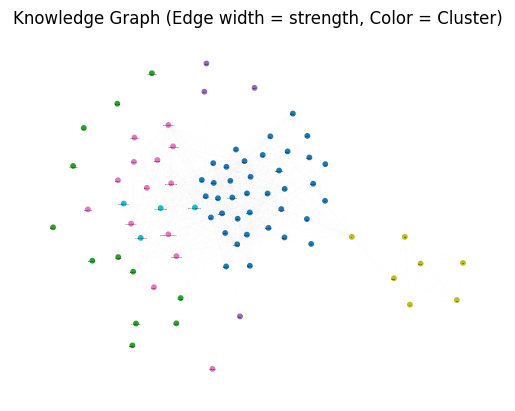

In [ ]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering

def render_graphs_from_file(include_texts=False):
    load_path = os.path.join('KG_data', 'ref_paper_KG.npy')
    keywords_dic = np.load(load_path, allow_pickle=True).item()

    keywords = keywords_dic['keywords']
    A = keywords_dic['A']

    A_dense = np.array(A.todense())

    # 聚类
    n_clusters = 6  # 可根据需要调整聚类数
    clustering = SpectralClustering(n_clusters=n_clusters, affinity='precomputed', assign_labels='kmeans', random_state=42)
    cluster_labels = clustering.fit_predict(A_dense)

    G = nx.Graph()
    for i, kw in enumerate(keywords):
        G.add_node(i, label=kw, cluster=cluster_labels[i])

    for i in range(len(keywords)):
        for j in range(i + 1, len(keywords)):
            weight = A_dense[i, j]
            if weight > 0:
                G.add_edge(i, j, weight=weight)

    pos = nx.spring_layout(G, seed=42, k=2.0)

    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    scaled_edge_widths = [w * 0.00003 for w in edge_weights]

    # 为不同聚类分配颜色
    colors = plt.cm.get_cmap('tab10', n_clusters)
    node_colors = [colors(cluster_labels[i]) for i in range(len(keywords))]

    nx.draw_networkx_nodes(G, pos, node_size=10, node_color=node_colors)
    nx.draw_networkx_edges(G, pos, width=scaled_edge_widths)
    nx.draw_networkx_labels(G, pos, labels={i: kw for i, kw in enumerate(keywords)}, font_size=1)
    plt.title("Knowledge Graph (Edge width = strength, Color = Cluster)")
    plt.axis('off')
    plt.show()

render_graphs_from_file(include_texts=True)
